## BMEB W4020: Circuits in the Brain 2023 Fall Homework #1 Solution

Author: [Shashwat Shukla](shashwat.shukla@columbia.edu), [Bruce Yi Bu](yb2520@columbia.edu)

Copyright 2022 Shashwat Shukla, Tingkai Liu, Bruce Yi Bu and Aurel A. Lazar

## Part 1

In [1]:
# Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)  # fix random seed

In [2]:
# Define spike detection function
def spike_detect(v, thresh):
    x = (v[2:-1] > v[1:-2]) * (v[2:-1] > v[3:]) * (v[2:-1] > thresh)
    x = np.append(False, x)
    x = np.append(x, False)
    return x

In [3]:
# TODO - define two functions for generating the input current 
# the functions should take the following forms
def I_in(t, a, K, f):
    out = np.zeros_like(t)
    for k in range(K + 1):
        out += a * np.sin(f * t - k * np.pi) / (f * t - k * np.pi)
    return out

In [4]:
# Wilson model dynamics
def hhw(t, I_ext):
    t = t*1000
    dt = t[1] - t[0]
    # Conductances and reverse potentials:
    E = [0.55, -0.92]
    g = [1.0, 26.0]
    # Time constant for R:
    tau_R = 1.9
    # Capacitance:
    C = 0.8
    # Initialize membrane voltage:
    V = np.zeros(len(t))
    V[0] = -0.7
    # Initialize internal currents:
    I = np.zeros((len(t), 2))
    # Initialize R:
    R = np.zeros(len(t))
    R[0] = 0.088

    # Perform numerical integration of the ODEs:
    for i in range(1, len(t)):
        R_infty = 1.35 * V[i - 1] + 1.03

        # Use exponential Euler numerical integration method to compute W:
        a = R_infty / tau_R
        b = 1 / tau_R
        D = np.exp(-b * dt)
        R[i] = R[i - 1] * D + (a / b) * (1 - D)

        # Update the ionic currents and membrane voltage:
        I[i] = (
            g
            * np.array([(17.81 + 47.71 * V[i - 1] + 32.63 * V[i - 1] ** 2), R[i - 1]])
            * (V[i - 1] - E)
        )
        V[i] = V[i - 1] + dt / C * (I_ext[i] - np.sum(I[i]))

    return V, R

In [5]:
dt = 1e-5  # set time step
t = np.arange(10 * dt, 0.2 + dt, dt)  # set time course

a_k = 0.2
Omega = 120*np.pi

I = I_in(t, a_k, 10, Omega)  # set external current
Vw, R = hhw(t, I)  # simulate Wilson neuron

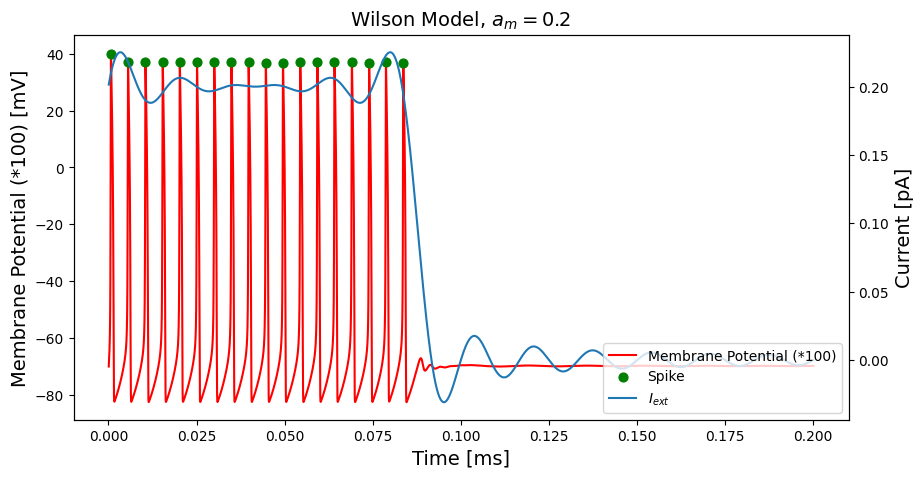

In [6]:
s = spike_detect(100 * Vw, 0)  # detect spike sequence
s = np.where(s == True)[0]

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100
fig, ax = plt.subplots()

ax.set_title(r"Wilson Model, $a_m =0.2$", fontsize=14)
ax.set_xlabel("Time [ms]", fontsize=14)
ax.set_ylabel("Membrane Potential (*100) [mV]", fontsize=14)
ax.plot(t,  100*Vw, label="Membrane Potential (*100)", color="red", zorder=0)
ax.scatter(t[s], Vw[s]*100, marker="o", color="green", s=40, label="Spike", zorder=1)

ax2 = ax.twinx()
ax2.set_ylabel("Current [pA]", fontsize=14)
ax2.plot(t, I, label=r"$I_{ext}$")

fig.legend(loc="lower right", bbox_to_anchor=(1, 0), bbox_transform=ax.transAxes)
plt.show()

In [7]:
a_k = np.arange(0.01,2,0.02)
count = []
amp = []
Vws=[]
for a in a_k:
    I = I_in(t, a, 10, Omega)  # set external current
    Vw, R = hhw(t, I)  # simulate Wilson neuron
    s = spike_detect(100 * Vw, 25)  # detect spike sequence
    s = np.where(s == True)[0]
    count.append(len(s))
    Vws.append(Vw)
    amp.append(np.mean(100 * Vw[s]))

count = np.array(count)
rate = count / 0.2
amp = np.array(amp)

/opt/anaconda3/envs/4020/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/4020/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


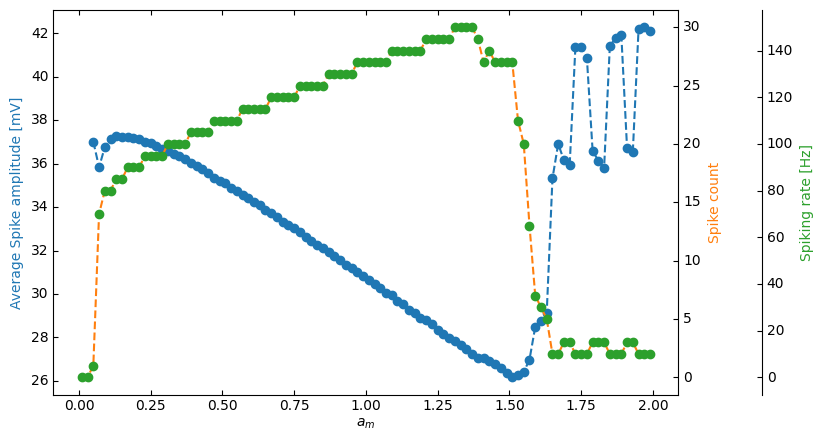

In [8]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2, offset=(offset, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.set_xlabel(r"$a_m$", fontsize=14)
host.set_ylabel("Average Spike amplitude [mV]", fontsize=14)
par1.set_ylabel("Spike count", fontsize=14)
par2.set_ylabel("Spiking rate [Hz]", fontsize=14)

(p1,) = host.plot(a_k, amp, linestyle="dashed", marker="o")
(p2,) = par1.plot(a_k, count, linestyle="dashed")
(p3,) = par2.plot(a_k, rate, linestyle="None", marker="o")

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

plt.draw()
plt.show()

In [9]:
# Wilson model vector field
def wilson_vf(V, R):
    dt = 1e-5
    # Conductances and reverse potentials:
    E = [0.55, -0.92]
    g = [1.0, 26.0]
    # Time constant for R:
    tau_R = 1.9
    # Capacitance:
    C = 0.8
    # External stimulus:
    I_ext = 1
    # Initialize membrane voltage and R:
    dV = np.zeros_like(V)
    dR = np.zeros_like(R)

    for i in range(V.shape[0]):
        for j in range(V.shape[1]):

            R_infty = 1.35 * V[i, j] + 1.03

            # Use exponential Euler numerical integration method to compute R:
            a = R_infty / tau_R
            b = 1 / tau_R
            D = np.exp(-b * dt)
            dR[i, j] = R[i, j] * D + (a / b) * (1 - D) - R[i, j]

            # Update the ionic currents and membrane voltage:
            I = (
                g
                * np.array([(17.81 + 47.71 * V[i, j] + 32.63 * V[i, j] ** 2), R[i, j]])
                * (V[i, j] - E)
            )
            dV[i, j] = dt / C * (I_ext - np.sum(I))

    return dV, dR

In [10]:
dt = 1e-5  # set time step
t = np.arange(0, 0.2 + dt, dt)  # set time course

# We analyze the phase response of Wilson Model for dV/dt = 0 and dR/dt = 0.
# When dV/dt = 0, R(V-E_K) = I_ext - g_Na(V)(V-E_Na)
V = np.arange(-0.9, 1.5 + 0.01, 0.01)  # set voltage range
R_dV_zero = (1 - (17.81 + 47.71 * V + 32.63 * V ** 2) * (V - 0.55)) / (V + 0.92) / 26

# When dR/dt = 0, R = R_infinity(V)
R_dR_zero = 1.35 * V + 1.03

# choose same limits as the limits of plot
Vgrid, Rgrid = np.meshgrid(np.arange(-100.1, 50 + 5, 5), np.arange(0, 1 + 0.05, 0.05))
dV, dR = wilson_vf(Vgrid / 100, Rgrid)

# Normalize vector fields according to their range
dV = dV / np.max(np.abs(dV))
dR = dR / np.max(np.abs(dR))

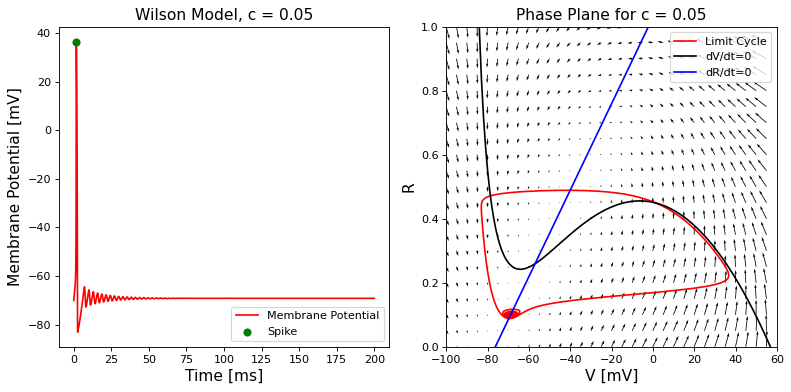

In [11]:
c = 0.05

I = c * np.ones_like(t)  # set external current
Vw, R = hhw(t, I)  # simulate Wilson neuron
s = spike_detect(100 * Vw, 20)  # detect spike sequence
s = np.where(s == True)[0]

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 80
fig, ax = plt.subplots(nrows=1, ncols=2)

#ax[0].set_xlim([0, 50])
ax[0].set_title("Wilson Model, c = {}".format(c), fontsize=14)
ax[0].set_xlabel("Time [ms]", fontsize=14)
ax[0].set_ylabel("Membrane Potential [mV]", fontsize=14)
ax[0].plot(1000*t, 100 * Vw, label="Membrane Potential", color="red", zorder=0)
ax[0].scatter(
   1000* t[s], 100 * Vw[s], marker="o", color="green", s=40, label="Spike", zorder=1
)
ax[0].legend(loc="lower right", bbox_transform=ax[0].transAxes)

ax[1].set_xlim([-100, 60])
ax[1].set_ylim([0, 1])
ax[1].set_title("Phase Plane for c = {}".format(c), fontsize=14)
ax[1].set_xlabel("V [mV]", fontsize=14)
ax[1].set_ylabel("R", fontsize=14)
ax[1].plot(100 * Vw, R, label="Limit Cycle", color="red")
ax[1].plot(100 * V, R_dV_zero, label="dV/dt=0", color="black")
ax[1].plot(100 * V, R_dR_zero, label="dR/dt=0", color="blue")
ax[1].quiver(Vgrid, Rgrid, dV, dR, scale=20)
ax[1].legend(loc="upper right", bbox_transform=ax[0].transAxes)

fig.tight_layout()
plt.show()

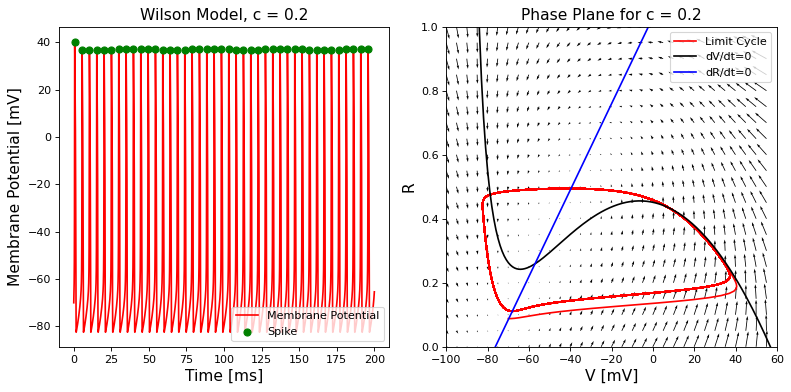

In [12]:
c = 0.2

I = c * np.ones_like(t)  # set external current
Vw, R = hhw(t, I)  # simulate Wilson neuron
s = spike_detect(100 * Vw, 20)  # detect spike sequence
s = np.where(s == True)[0]

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 80
fig, ax = plt.subplots(nrows=1, ncols=2)

#ax[0].set_xlim([0, 50])
ax[0].set_title("Wilson Model, c = {}".format(c), fontsize=14)
ax[0].set_xlabel("Time [ms]", fontsize=14)
ax[0].set_ylabel("Membrane Potential [mV]", fontsize=14)
ax[0].plot(1000*t, 100 * Vw, label="Membrane Potential", color="red", zorder=0)
ax[0].scatter(
    t[s]*1000, 100 * Vw[s], marker="o", color="green", s=40, label="Spike", zorder=1
)
ax[0].legend(loc="lower right", bbox_transform=ax[0].transAxes)

ax[1].set_xlim([-100, 60])
ax[1].set_ylim([0, 1])
ax[1].set_title("Phase Plane for c = {}".format(c), fontsize=14)
ax[1].set_xlabel("V [mV]", fontsize=14)
ax[1].set_ylabel("R", fontsize=14)
ax[1].plot(100 * Vw, R, label="Limit Cycle", color="red")
ax[1].plot(100 * V, R_dV_zero, label="dV/dt=0", color="black")
ax[1].plot(100 * V, R_dR_zero, label="dR/dt=0", color="blue")
ax[1].quiver(Vgrid, Rgrid, dV, dR, scale=20)
ax[1].legend(loc="upper right", bbox_transform=ax[0].transAxes)

fig.tight_layout()
plt.show()

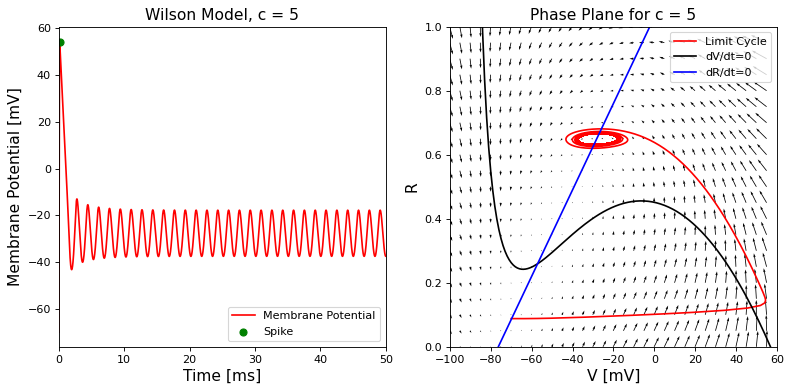

In [13]:
c = 5

I = c * np.ones_like(t)  # set external current
Vw, R = hhw(t, I)  # simulate Wilson neuron
s = spike_detect(100 * Vw, 20)  # detect spike sequence
s = np.where(s == True)[0]

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 80
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].set_xlim([0, 50])
ax[0].set_title("Wilson Model, c = {}".format(c), fontsize=14)
ax[0].set_xlabel("Time [ms]", fontsize=14)
ax[0].set_ylabel("Membrane Potential [mV]", fontsize=14)
ax[0].plot(1000*t, 100 * Vw, label="Membrane Potential", color="red", zorder=0)
ax[0].scatter(
    1000*t[s], 100 * Vw[s], marker="o", color="green", s=40, label="Spike", zorder=1
)
ax[0].legend(loc="lower right", bbox_transform=ax[0].transAxes)

ax[1].set_xlim([-100, 60])
ax[1].set_ylim([0, 1])
ax[1].set_title("Phase Plane for c = {}".format(c), fontsize=14)
ax[1].set_xlabel("V [mV]", fontsize=14)
ax[1].set_ylabel("R", fontsize=14)
ax[1].plot(100 * Vw, R, label="Limit Cycle", color="red")
ax[1].plot(100 * V, R_dV_zero, label="dV/dt=0", color="black")
ax[1].plot(100 * V, R_dR_zero, label="dR/dt=0", color="blue")
ax[1].quiver(Vgrid, Rgrid, dV, dR, scale=20)
ax[1].legend(loc="upper right", bbox_transform=ax[0].transAxes)

fig.tight_layout()
plt.show()

We see that for c = 0.05, the phase-space trajectory converges to a point atrractor. Observe that after the first (and only) spike, the trajectory never crosses the $dV/dt$ nullcline again. Such behavior is observed for $c < 0.07$.

For c = 0.2, the phase-space trajectory converges onto a limit cycle and the neuron is firing periodically. Note that this in instance the trajectory crosses each of the nullclines for $dV/dt$ and $dR/dt$ twice during one trip around the limit cycle, producing the spiking behavior. Furthermore, the limit cycle goes below the minima of the $dV/dt$ nullcline, which produces the refractory period after each spike. Such behavior is observed for $c \in (0.07,1.1)$.

For c = 1.8, the phase-space trajectory converges onto a limit cycle and the membrane voltage displays spikes but no (significant) refractory periods. The trajectory crosses each of the nullclines for $dV/dt$ and $dR/dt$ twice during one trip around the limit cycle, producing the spiking behavior. However, the limit cycle does not go below the minima of the $dV/dt$ nullcline, and so no there is no refractory period after each spike. Such behavior is observed for $c \in (1.1,2.8)$.


For c = 5, the phase-space trajectory converges onto a limit cycle but the neuron is not firing. This is evidenced by the lack of a sharp spike followed by a refractory period (instead the membrane voltage is oscillating quite regularly). In phase-space we see that the neuron's trajectory does not cross the $dV/dt$ nullcline (except once in the beginning) and thus does not undergo the dynamics that generates a spike. Such behavior is observed for $c > 2.8$.

Thus we conclude that the Wilson neuron spikes akin to a "standard" biological neuron (displaying spikes as well as refractory periods) in the range $0.07 < c < 2.8$.

## Part 2

1. The relevant equations are:
$$
\begin{align}
I_{R} &= g_R\cdot R\cdot(V-E_R)\\
\tau_R\frac{dR}{dt} &= -R + 1.35V + 1.03 \\
\end{align}
$$

$V$ can be found by numerically solving these coupled differential equations for a given input current. 

2. No, it is not, as the there can be two possible values of voltage for the same value of current.
3. Yes, as observed via simulation.

Simulations for part 2 and 3 follow.

In [14]:
from collections import OrderedDict
import typing as tp
from compneuro.base_model import BaseModel
import bokeh as bk
from bokeh.io import output_notebook
import bokeh.plotting
import bokeh.layouts
import bokeh.models
output_notebook()  # render Bokeh animations inline

Loading BokehJS ...

In [15]:
def plot_memristor(
    signals_db: "bokeh.models.layouts.ColumnDataSource",
    title: str = "",
    memristor_type: tp.Union["HP", "Ion-Channel"] = "HP",
    plot_rate: int = 1,
) -> "bokeh.models.layouts.GridBox":
    """Plot Memristor Plots From Signals
    
    Arguments:
        signals: A ColumnDataSource of memristor data containing fields:
        
             - t: Time vector
             - V: Voltage Traces
             - I: Current Traces
             - x: Internal States
             - M: Memristances
             - Q: Charges
             - F: Flux
             - colors: color of each trace
        
        title: title of the figure
        memristor_type: type of memristor
        
            - HP: HP-Memristors
            - Ion-Channel: HHN Ion Channel as Memristors
        
        plot_rate: results will be visualized every :code:`plot_rate` indices
             
    Returns:
        A bokeh.models.layouts.GridBox instance that can be shown
        using :func:`bokeh.plotting.show` function.
    """
    # construct bokeh plots
    TOOLS = "box_zoom, reset"
    input_types = list(signals_db.keys())

    signals_db_plot = {inp_type: None for inp_type, ds in signals_db.items()}
    for inp_type, ds in signals_db.items():
        _col = bk.models.ColumnDataSource(
            {
                var_name: list(np.vstack(val)[:, ::plot_rate])
                if var_name != "colors"
                else val
                for var_name, val in ds.data.items()
            }
        )
        signals_db_plot[inp_type] = _col

    # Make a deepcopy of the first signal data source to act as initial value
    # for the bokeh JS callback. A deep copy is required in this case to avoid
    # the error when switch back to the starting input type in the dropdown menu
    signals = bk.models.ColumnDataSource(
        {key: val for key, val in signals_db_plot[input_types[0]].data.items()}
    )

    if memristor_type.upper() == "HP":
        variables = dict(
            t=dict(label="Time [sec]", fmt=None),
            V=dict(label="Voltage [V]", fmt=None),
            I=dict(label="Current [A]", fmt=None),
            x=dict(label="Internal State [A*s]", fmt=None),
            M=dict(label="Memristance [Ohm]", fmt=None),
            Q=dict(
                label="Charge [A*s]", fmt=bk.models.NumeralTickFormatter(format="0.000")
            ),
            F=dict(label="Flux [W]", fmt=None),
        )
        subplot_config = [
            dict(xs="t", ys="V", width=350, height=150, row=0, col=0),
            dict(xs="t", ys="I", width=350, height=150, row=1, col=0),
            dict(xs="t", ys="x", width=350, height=150, row=0, col=1),
            dict(xs="t", ys="M", width=350, height=150, row=1, col=1),
            dict(xs="V", ys="I", width=350, height=250, row=2, col=0),
            dict(xs="I", ys="M", width=350, height=250, row=2, col=1),
            dict(xs="F", ys="Q", width=350, height=250, row=3, col=0),
            dict(xs="Q", ys="M", width=350, height=250, row=3, col=1),
        ]
        figs = np.full((4, 2), None, dtype=object)
    elif memristor_type.upper() == "ION-CHANNEL":
        variables = dict(
            t=dict(label="Time [sec]", fmt=None),
            V=dict(label="Voltage [V]", fmt=None),
            I=dict(label="Current [A]", fmt=None),
            G=dict(label="Memconductance [S]", fmt=None),
            Q=dict(label="Charge [A*s]", fmt=None),
            F=dict(label="Flux [W]", fmt=None),
        )
        subplot_config = [
            dict(xs="t", ys="V", width=350, height=150, row=0, col=0),
            dict(xs="t", ys="I", width=350, height=150, row=1, col=0),
            dict(xs="t", ys="G", width=350, height=300, row=1, col=1),
            dict(xs="I", ys="V", width=350, height=250, row=2, col=0),
            dict(xs="V", ys="G", width=350, height=250, row=2, col=1),
            dict(xs="Q", ys="F", width=350, height=250, row=3, col=0),
            dict(xs="F", ys="G", width=350, height=250, row=3, col=1),
        ]
        figs = np.full((4, 2), None, dtype=object)
    else:
        raise ValueError(f"memristor type '{memristor_type}' not understood.")

    for n, cfg in enumerate(subplot_config):
        _xs, _ys = cfg["xs"], cfg["ys"]
        _x_label = variables[_xs]["label"]
        _y_label = variables[_ys]["label"]
        ttl = f"{_y_label} vs. {_x_label}"
        fig = bk.plotting.figure(
            tools=TOOLS,
            title=ttl,
            width=cfg["width"],
            height=cfg["height"],
        )
        fig.title.text_font_size = '12pt'
        fig.title.align = "center"
        fig.yaxis.axis_label = _y_label
        fig.yaxis.axis_label_text_font_style = "normal"
        if variables[_xs]["fmt"] is not None:
            fig.xaxis.formatter = variables[_xs]["fmt"]
        if variables[_ys]["fmt"] is not None:
            fig.yaxis.formatter = variables[_ys]["fmt"]
        fig.xaxis.axis_label = _x_label
        fig.xaxis.axis_label_text_font_style = "normal"
        fig.multi_line(xs=_xs, ys=_ys, color="colors", source=signals, line_width=2)
        figs[cfg["row"], cfg["col"]] = fig

    # signal select
    signalSelect = bk.models.CustomJS(
        args=dict(
            signals_db=signals_db_plot,
            signals=signals,
            supported_signals=input_types,
            variables=list(variables.keys()),
        ),
        code="""
        const input_type = cb_obj.value;
        
        if (supported_signals.includes(input_type)) {
            for (const var_name of variables) {
                signals.data[var_name] = signals_db[input_type].data[var_name];
            }
            signals.change.emit();
        }
        """,
    )
    stype = bk.models.Select(title="Signal Type:", options=input_types)
    stype.js_on_change("value", signalSelect)

    controls = [bk.models.Div(text=f"<b> {title}</b>"), stype]
    if memristor_type.upper() == "ION-CHANNEL":
        layout = bk.layouts.grid(
            [
                [controls],
                [bk.layouts.row(bk.layouts.column(figs[0, 0], figs[1, 0]), figs[1, 1])],
                [figs[2, 0], figs[2, 1]],
                [figs[3, 0], figs[3, 1]],
            ]
        )
    else:
        layout = bk.layouts.grid(controls + figs.tolist())
    return layout

In [16]:
# define model class
class RMemristor(BaseModel):
    Time_Scale = 1.0
    Default_States = OrderedDict(R=0.01)
    Default_Params = OrderedDict(tau_R=1.9, E_R=0.55, g_R=1.0)
    """Default Parameters of the Soft Switching Memristor Model"""

    def ode(self, t, states, I_ext=0.0):
        """Memristor gradient function"""
        I_R = I_ext
        R = states
        M = self.params["g_R"] * R
        V = I_R / M + self.params["E_R"]
        d_R = (-R + 1.35 * V + 1.03) / self.params["tau_R"]
        return d_R

In [17]:
# input currents
dt = 1e-4  # Set time step

I_range = 0.1 * np.linspace(5, 20, 4)  # Set of input current amplitudes
t_parabolic = np.arange(0, 6, dt)  # Set time course
t_seg = np.arange(0, 2, dt)
mask_seg = (t_seg - np.max(t_seg) / 2) ** 2
mask_seg = 0.5 * (mask_seg - np.max(mask_seg)) / np.max(mask_seg)
mask = np.zeros_like(t_parabolic)
mask = np.tile(mask_seg, np.ceil(len(t_parabolic) / len(t_seg)).astype(int))[
    : len(t_parabolic)
]
I_parabolic = np.outer(I_range, mask)  # Get input current signal

f_range = np.array([400, 600, 800, 1000])  # Set poisson frequency
t_poisson = np.arange(0, 4, dt)  # Set time course
I_poisson = []
for i in np.arange(len(f_range)):
    spikes = 1.0 * (np.random.rand(len(t_poisson)) < f_range[i] * dt)
    I_poisson.append(0.05 * spikes)
I_poisson = np.array(I_poisson)

In [18]:
# simulate model
rm = RMemristor(num=len(I_range))  # instantiate R memristor model
input_types = [
    "parabolic",
    "poisson",
]
ds = 10
signals_db = {inp: None for inp in input_types}
for name in input_types:
    t = globals()[f"t_{name}"]
    I = -globals()[f"I_{name}"] # negative sign to account for current convention
    N_trials = I.shape[0]
    rm_result = rm.solve(
        t, I_ext=I.T, solver="Euler", verbose=False
    )  # Simulate the memristor
    R = rm_result["R"]
    G = rm.params["g_R"] * R
    V = I / G + rm.params["E_R"]
    Q = dt * np.cumsum(I, axis=1)
    F = dt * np.cumsum(V, axis=1)

    signals_db[name] = bk.models.ColumnDataSource(
        dict(
            t=list(np.repeat(t[10::ds][None, :], rm.num, axis=0)),
            V=list(V[:, 10::ds]),
            I=list(I[:, 10::ds]),
            G=list(G[:, 10::ds]),
            Q=list(Q[:, 10::ds]),
            F=list(F[:, 10::ds]),
            colors=bk.palettes.viridis(rm.num),
        )
    )
    

# plot results
fig = plot_memristor(signals_db, title="R channel", memristor_type="ion-channel", plot_rate=50)
# render figure
bk.io.show(fig)